In [51]:
import os
import tqdm

import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import SubsetRandomSampler

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

from privacy_lint.attacks.loss import LossAttack, compute_loss_cross_entropy

%matplotlib inline  
%config InlineBackend.figure_format='retina'

Gather train and test scores
====

In [29]:
def get_dataloader(path, batch_size=256, num_workers=8, train=True):
    
    num_samples = 50000 if train else 10000
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    dataset = datasets.ImageFolder(
        path, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]))
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size, 
        sampler=SubsetRandomSampler(torch.randint(0, len(dataset), (num_samples,))),
        num_workers=num_workers, 
        pin_memory=True
    )
    
    return dataloader

In [32]:
imagenet_path = "/datasets01/imagenet_full_size/061417/"
batch_size = 1024

model = models.resnet18(pretrained=True).eval()


train_path = os.path.join(imagenet_path, 'train')
test_path = os.path.join(imagenet_path, 'val')
train_loader = get_dataloader(train_path, batch_size=batch_size, train=True)
test_loader = get_dataloader(test_path, batch_size=batch_size, train=False)

Attack unbalanced
====

When not balancing the dataset, it's way easier to attack!

In [34]:
attack = LossAttack(compute_loss=compute_loss_cross_entropy)
loss_results_unbalanced = attack.launch(model, train_loader, test_loader)

100%|██████████| 10/10 [00:50<00:00,  5.02s/it]


In [35]:
max_accuracy_threshold, max_accuracy = loss_results_unbalanced.get_max_accuracy_threshold()
print(f"Max accuracy threshold: {-max_accuracy_threshold:.2f}, max accuracy: {max_accuracy*100:.2f}%")

Max accuracy threshold: 13.91, max accuracy: 83.34%


Attack balanced
===

The accuracy when balancing drops to 55%

In [36]:
loss_results_balanced = loss_results_unbalanced.balance()

max_accuracy_threshold, max_accuracy = loss_results_balanced.get_max_accuracy_threshold()
print(f"Max accuracy threshold: {-max_accuracy_threshold:.2f}, max accuracy: {max_accuracy*100:.2f}%")

Max accuracy threshold: 0.71, max accuracy: 55.21%


Loss distributions
====

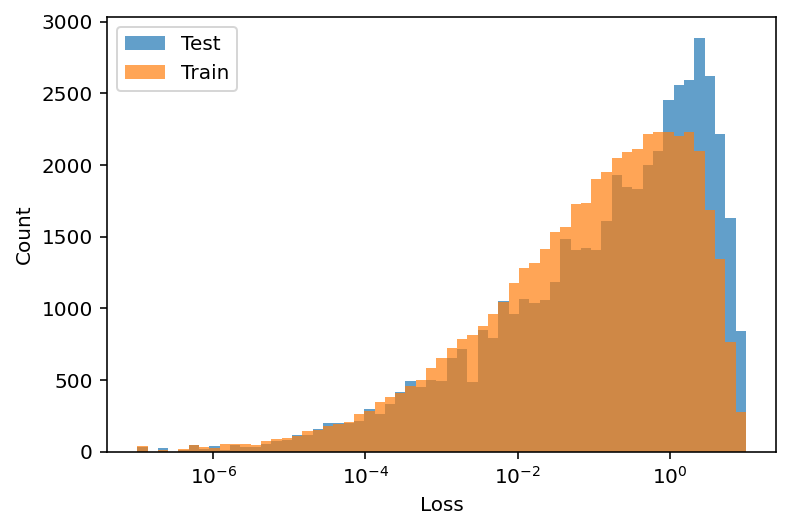

In [55]:
plt.hist(-loss_results_balanced.scores_test.numpy(), label="Test", bins=np.logspace(-7, 1, 60), alpha=0.7)
plt.hist(-loss_results_balanced.scores_train.numpy(), label="Train", bins=np.logspace(-7, 1, 60), alpha=0.7)
plt.xscale("log")
plt.xlabel("Loss")
plt.ylabel("Count")
plt.legend()
plt.show()